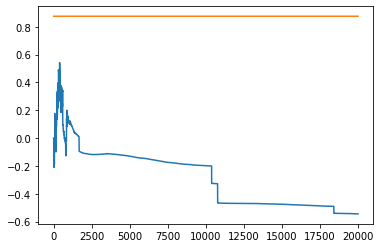

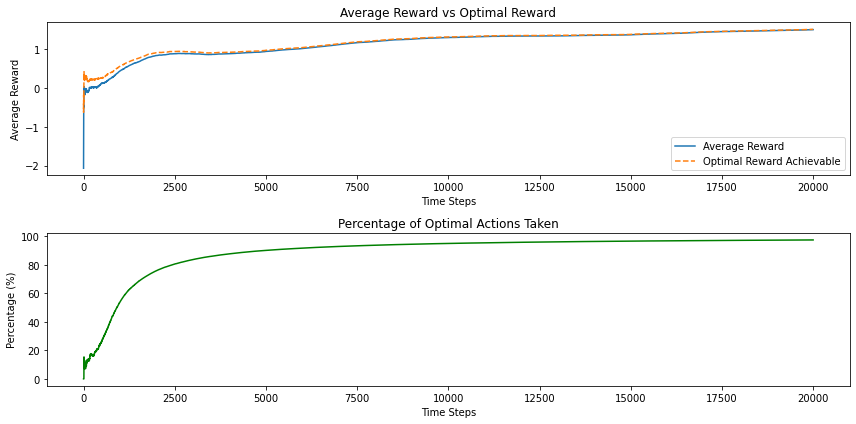

In [34]:
import numpy as np
import matplotlib.pyplot as plt

class GradientBandit:
    def __init__(self, n_actions, alpha, baseline=True):
        self.n_actions = n_actions      # Number of actions (k-armed bandit)
        self.alpha = alpha              # Step size (learning rate)
        self.baseline = baseline        # Use average reward as baseline
        self.action_preferences = np.zeros(n_actions)  # Initial preferences (H)
        self.action_counts = np.zeros(n_actions)       # Track action counts
        self.average_reward = 0         # Average reward for baseline
        self.total_steps = 0            # Total steps taken

    def get_probabilities(self):
        """Convert action preferences to a probability distribution."""
        exp_prefs = np.exp(self.action_preferences)
        return exp_prefs / np.sum(exp_prefs)

    def select_action(self):
        """Select an action based on the current probability distribution."""
        probabilities = self.get_probabilities()
        return np.random.choice(self.n_actions, p=probabilities)

    def update(self, action, reward):
        """Update action preferences based on the received reward."""
        self.total_steps += 1
        self.action_counts[action] += 1
        
        # Update average reward if using baseline
        if self.baseline:
            self.average_reward += (reward - self.average_reward) / self.total_steps
        
        # Calculate the difference between reward and baseline (average reward)
        baseline = self.average_reward if self.baseline else 0
        reward_diff = reward - baseline
        
        # Get probabilities again after action taken
        probabilities = self.get_probabilities()

        # Update action preferences for the taken action
        self.action_preferences[action] += self.alpha * reward_diff * (1 - probabilities[action])

        # Update the other action preferences (those not taken)
        for a in range(self.n_actions):
            if a != action:
                self.action_preferences[a] -= self.alpha * reward_diff * probabilities[a]


# Simulating nonstationary rewards (moving averages)
def simulate_bandit_problem(n_actions, time_steps):
    # Random walk of true values for each action
    true_values = np.zeros(n_actions)
    rewards = np.zeros((n_actions, time_steps))
    
    for t in range(time_steps):
        # Rewards change with each time step to simulate nonstationary behavior
        true_values += np.random.normal(0, 0.01, n_actions)  # Random walk
        rewards[:, t] = np.random.normal(true_values, 1)  # Generate rewards with noise
        
    return rewards, true_values


def run_experiment(n_actions=10, time_steps=1000, alpha=0.1, baseline=True):
    bandit = GradientBandit(n_actions, alpha, baseline)
    rewards_history = []
    optimal_rewards_history = []
    optimal_action_taken = []
    
    action_to_study = 6
    action_preferences = []
    true_values_list = []
    
    # Simulating nonstationary bandit problem
    rewards, true_values = simulate_bandit_problem(n_actions, time_steps)

    for t in range(time_steps):
        # Select an action
        action = bandit.select_action()

        # Get reward for selected action
        reward = rewards[action, t]
        
        # Get Action estimate and true values
        action_preferences.append(bandit.action_preferences[action_to_study])
        true_values_list.append(true_values[action_to_study])

        # Update the bandit algorithm with action and reward
        bandit.update(action, reward)

        # Track total reward history
        rewards_history.append(reward)

        # Track the optimal reward achievable at this step
        optimal_action = np.argmax(true_values)
        optimal_rewards_history.append(rewards[optimal_action, t])

        # Track if the optimal action was taken
        optimal_action_taken.append(1 if action == optimal_action else 0)
        
    
    plt.plot(action_preferences)
    plt.plot(true_values_list)

    return np.array(rewards_history), np.array(optimal_rewards_history), np.array(optimal_action_taken)


# Run the experiment and plot results
if __name__ == "__main__":
    np.random.seed(1)
    n_actions = 10
    time_steps = 20000
    alpha = 0.1

    rewards_history, optimal_rewards_history, optimal_action_taken = run_experiment(n_actions=n_actions, time_steps=time_steps, alpha=alpha)

    # Calculate average reward and percentage of optimal action over time
    avg_reward = np.cumsum(rewards_history) / (np.arange(len(rewards_history)) + 1)
    avg_optimal_reward = np.cumsum(optimal_rewards_history) / (np.arange(len(optimal_rewards_history)) + 1)
    percentage_optimal_action = np.cumsum(optimal_action_taken) / (np.arange(len(optimal_action_taken)) + 1) * 100

    # Plot the average reward over time
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(avg_reward, label='Average Reward')
    plt.plot(avg_optimal_reward, label='Optimal Reward Achievable', linestyle='--')
    plt.xlabel('Time Steps')
    plt.ylabel('Average Reward')
    plt.title('Average Reward vs Optimal Reward')
    plt.legend()

    # Plot the percentage of optimal actions taken over time
    plt.subplot(2, 1, 2)
    plt.plot(percentage_optimal_action, label='% Optimal Action Taken', color='green')
    plt.xlabel('Time Steps')
    plt.ylabel('Percentage (%)')
    plt.title('Percentage of Optimal Actions Taken')

    plt.tight_layout()
    plt.show()


In [32]:
class Bandit():

    def __init__(self, n_bandits, max_steps):
        self.n_bandits = n_bandits
        self.max_steps = max_steps

        self.dev_reward = 1
        self.randomwalk_mean = 0
        self.randomwalk_std = 0.01

        self.reset()

    
    def reset(self):
        self.mean_reward_per_step = []
        self.optimal_reward_per_step = []
        self.median_reward_per_step = []
        self.optimal_action_pct = []
        self.n_optimal_actions = 0
        self.total_reward = 0
        self.opt_total_reward = 0
        self.median_total_reward = 0
        self.q_stars = np.zeros(self.n_bandits)
        self.curr_steps = 0
        self.done = False

    
    def step(self, action):
        # Update number of steps
        self.curr_steps += 1
        
        # Update Optimal Action Counting
        opt_action = np.argmax(self.q_stars)
        median_action = np.argsort(self.q_stars)[len(self.q_stars)//2]
        opt_act_value = self.q_stars[opt_action]
        act_value = self.q_stars[action]
        if act_value == opt_act_value:
            self.n_optimal_actions +=1
        self.optimal_action_pct.append(self.n_optimal_actions/self.curr_steps)

        # Computing Reward and appending to reward list
        reward = np.random.normal(act_value, self.dev_reward)
        
        self.total_reward += reward
        self.mean_reward_per_step.append(self.total_reward/self.curr_steps)
        # Computing Optimal Reward and appending to optimal reward list
        opt_reward = np.random.normal(self.q_stars[opt_action], self.dev_reward)
        self.opt_total_reward += opt_reward
        self.optimal_reward_per_step.append(self.opt_total_reward/self.curr_steps)
        # Computing Worst Reward and appending to optimal reward list
        median_reward = np.random.normal(self.q_stars[median_action], self.dev_reward)
        self.median_total_reward += median_reward
        self.median_reward_per_step.append(self.median_total_reward/self.curr_steps)

        # Updating action values
        self.q_stars += np.random.normal(self.randomwalk_mean, self.randomwalk_std, self.q_stars.shape)

        if self.curr_steps == self.max_steps:
            self.done = True
            
        return reward, self.done

    
    def plot_results(self):
        fig, axes = plt.subplots(2, 1, figsize=(20, 20))

        axes[0].plot(self.mean_reward_per_step, label="Mean reward achieved")
        axes[0].plot(self.optimal_reward_per_step, label="Optimal reward achievable")
        axes[0].plot(self.median_reward_per_step, label="Median reward achievable")
        axes[0].set_xlabel("Steps")
        axes[0].set_ylabel("Average Reward")
        axes[0].set_title("Mean Reward per step")
        axes[0].legend()
        

        axes[1].plot(np.array(self.optimal_action_pct)*100, label="Optimal Action Percentage")
        axes[1].set_xlabel("Steps")
        axes[1].set_ylabel("% of Optimal Actions")
        axes[1].set_title("% of Optimal Actions per step")
        axes[1].legend()
            

    def get_results(self):
        return self.mean_reward_per_step, self.optimal_action_pct

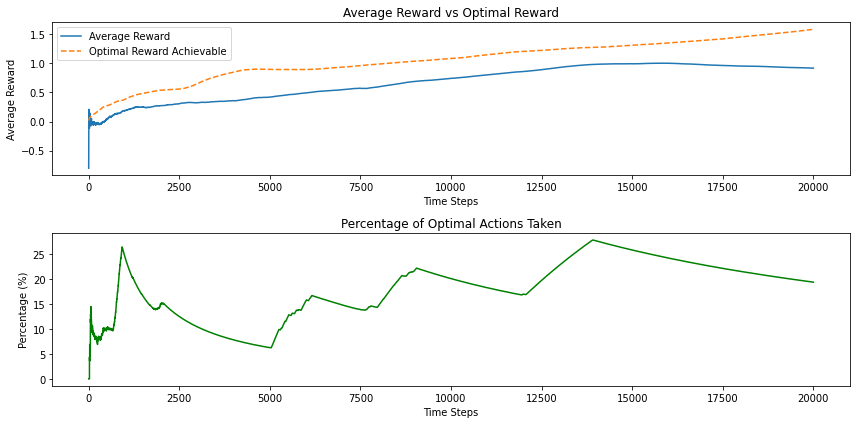

In [33]:
def run_experiment(n_actions=10, time_steps=1000, alpha=0.1, baseline=True):
    bandit = GradientBandit(n_actions, alpha, baseline)
    rewards_history = []
    optimal_rewards_history = []
    optimal_action_taken = []
    
    # Simulating nonstationary bandit problem
    env = Bandit(n_actions, time_steps)
    env.reset()

    for t in range(time_steps):
        # Select an action
        action = bandit.select_action()

        # Get reward for selected action
        reward, _ = env.step(action)

        # Update the bandit algorithm with action and reward
        bandit.update(action, reward)

        # Track total reward history
        rewards_history.append(reward)

        # Track the optimal reward achievable at this step
        optimal_action = np.argmax(env.q_stars)
        optimal_rewards_history.append(env.q_stars[optimal_action])

        # Track if the optimal action was taken
        optimal_action_taken.append(1 if action == optimal_action else 0)

    return np.array(rewards_history), np.array(optimal_rewards_history), np.array(optimal_action_taken)


# Run the experiment and plot results
if __name__ == "__main__":
    np.random.seed(1)
    n_actions = 10
    time_steps = 20000
    alpha = 0.1

    rewards_history, optimal_rewards_history, optimal_action_taken = run_experiment(n_actions=n_actions, time_steps=time_steps, alpha=alpha)

    # Calculate average reward and percentage of optimal action over time
    avg_reward = np.cumsum(rewards_history) / (np.arange(len(rewards_history)) + 1)
    avg_optimal_reward = np.cumsum(optimal_rewards_history) / (np.arange(len(optimal_rewards_history)) + 1)
    percentage_optimal_action = np.cumsum(optimal_action_taken) / (np.arange(len(optimal_action_taken)) + 1) * 100

    # Plot the average reward over time
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(avg_reward, label='Average Reward')
    plt.plot(avg_optimal_reward, label='Optimal Reward Achievable', linestyle='--')
    plt.xlabel('Time Steps')
    plt.ylabel('Average Reward')
    plt.title('Average Reward vs Optimal Reward')
    plt.legend()

    # Plot the percentage of optimal actions taken over time
    plt.subplot(2, 1, 2)
    plt.plot(percentage_optimal_action, label='% Optimal Action Taken', color='green')
    plt.xlabel('Time Steps')
    plt.ylabel('Percentage (%)')
    plt.title('Percentage of Optimal Actions Taken')

    plt.tight_layout()
    plt.show()
